**UNIVERSIDADE DE SÃO PAULO**<br>
**MBA DATA SCIENCE & ANALYTICS USP/ESALQ**<br>
**SUPERVISED MACHINE LEARNING: MODELOS PARA DADOS DE CONTAGEM**<br>
**Prof. Dr. Luiz Paulo Fávero**<br>
Aluna: Luiza Batista Laquini<br>
Turma: DSA 241<br>

*coding: utf-8*

In [22]:
# In[0.1]: Instalação dos pacotes

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install statstests

In [23]:
# In[0.2]: Importação dos pacotes

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import matplotlib.image as mpimg # carregar imagem 
import urllib.request
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação de modelos de contagem
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson
# pacote acima para a estimação dos modelos ZINB e ZIP, respectivamente
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
# pacote anterior para a realização do teste de Vuong
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statstests.tests import overdisp
from math import exp, factorial # funções matemáticas 'exp' e 'factorial'
from tqdm import tqdm # para mostrar o progresso do loop
from PIL import Image
#from playsound import playsound # não foi possível instalar 

import warnings
warnings.filterwarnings('ignore')

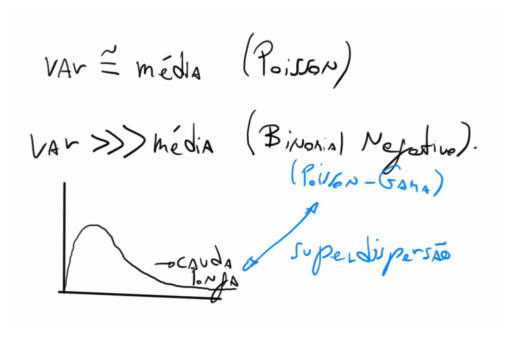

In [24]:
# Complementar
# Carregar a imagem
img = mpimg.imread('images/output_conceito.png')

# Exibir a imagem
#plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

In [25]:
# In[POISSON]:
##############################################################################
#                          A DISTRIBUIÇÃO POISSON                            #
##############################################################################

#Estabelecendo uma função da distribuição Poisson para determinados valores
#de lambda
def poisson_lambda(lmbda,m):
    return (exp(-lmbda) * lmbda ** m) / factorial(m)

# In[Poisson 1]: Plotagem da função definida para diferentes valores de lambda

m = np.arange(0,21)

lmbda_1 = []
lmbda_2 = []
lmbda_4 = []

for item in m:
    # Estabelecendo a distribuição com lambda = 1
    lmbda_1.append(poisson_lambda(1,item))
    # Estabelecendo a distribuição com lambda = 2
    lmbda_2.append(poisson_lambda(2,item))
    # Estabelecendo a distribuição com lambda = 4
    lmbda_4.append(poisson_lambda(4,item))

# Criando um dataframe com m variando de 0 a 20 e diferentes valores de lambda
df_lambda = pd.DataFrame({'m':m,
                          'lambda_1':lmbda_1,
                          'lambda_2':lmbda_2,
                          'lambda_4':lmbda_4})
df_lambda

,m,lambda_1,lambda_2,lambda_4
0,0,3.678794e-01,1.353353e-01,0.018316
1,1,3.678794e-01,2.706706e-01,0.073263
2,2,1.839397e-01,2.706706e-01,0.146525
3,3,6.131324e-02,1.804470e-01,0.195367
4,4,1.532831e-02,9.022352e-02,0.195367
5,5,3.065662e-03,3.608941e-02,0.156293
6,6,5.109437e-04,1.202980e-02,0.104196
7,7,7.299195e-05,3.437087e-03,0.059540
8,8,9.123994e-06,8.592716e-04,0.029770
9,9,1.013777e-06,1.909493e-04,0.013231


<function matplotlib.pyplot.show(close=None, block=None)>

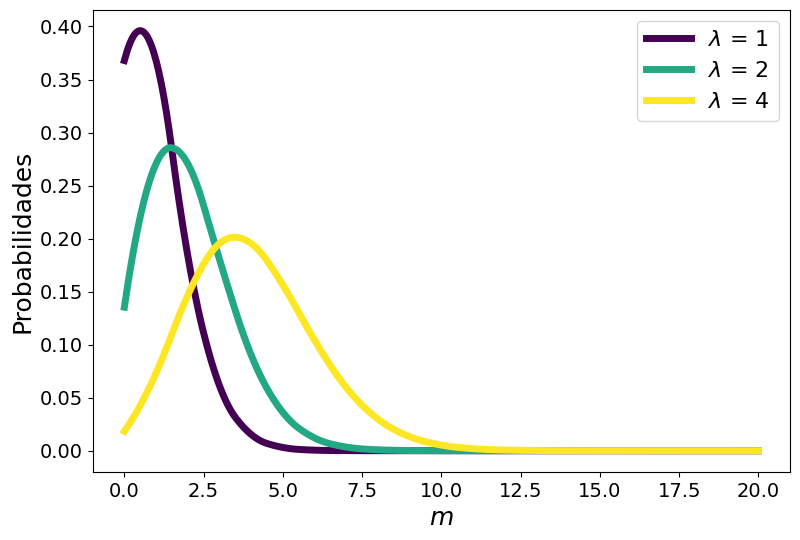

In [26]:
# In[Poisson 2]: Plotagem propriamente dita

from scipy.interpolate import interp1d

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, lambda_1 = smooth_line_plot(df_lambda.m, df_lambda.lambda_1)
x_new, lambda_2 = smooth_line_plot(df_lambda.m, df_lambda.lambda_2)
x_new, lambda_4 = smooth_line_plot(df_lambda.m, df_lambda.lambda_4)

plt.figure(figsize=(9,6))
plt.plot(x_new, lambda_1, linewidth=5, color='#440154FF')
plt.plot(x_new, lambda_2, linewidth=5, color='#22A884FF')
plt.plot(x_new, lambda_4, linewidth=5, color='#FDE725FF')
plt.xlabel('m', fontsize=18, style='italic')
plt.ylabel('Probabilidades', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([r'$\lambda$ = 1',r'$\lambda$ = 2',r'$\lambda$ = 4'], fontsize=16)
plt.show

**Um dado de contagem possui 4 características:**<br>
1. é quant
2. inteiro
3. não negativo
4. para determinada exposição (unidade temporal, espacial...)

In [27]:
# In[EXEMPLO]:
##############################################################################
#                      REGRESSÃO PARA DADOS DE CONTAGEM                      #
#                 CARREGAMENTO DA BASE DE DADOS 'corruption'                 #
##############################################################################

# Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence
#from Diplomatic Parking Tickets.
# Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
# https://www.journals.uchicago.edu/doi/abs/10.1086/527495

df_corruption = pd.read_csv('data/corruption.csv', delimiter=',')
df_corruption.head(6)

,country,code,violations,staff,post,corruption
0,Angola,AGO,50,9,no,1.047506
1,Angola,AGO,1,9,yes,1.047506
2,Albania,ALB,17,3,no,0.921079
3,Albania,ALB,0,3,yes,0.921079
4,United Arab Emirates,ARE,0,3,no,-0.779468
5,United Arab Emirates,ARE,0,3,yes,-0.779468


In [28]:
# Características das variáveis do dataset
df_corruption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


In [29]:
# Estatísticas univariadas
df_corruption.describe()

,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [30]:
# In[1]: Tabela de frequências da variável dependente 'violations'
# Função 'values_counts' do pacote 'pandas', sem e com o argumento
#'normalize=True', para gerar as contagens e os percentuais, respectivamente

contagem = df_corruption['violations'].value_counts(dropna=False)

percent = (df_corruption['violations'].value_counts(dropna=False, normalize=True)*100).round(2)
table = pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=True)
#table

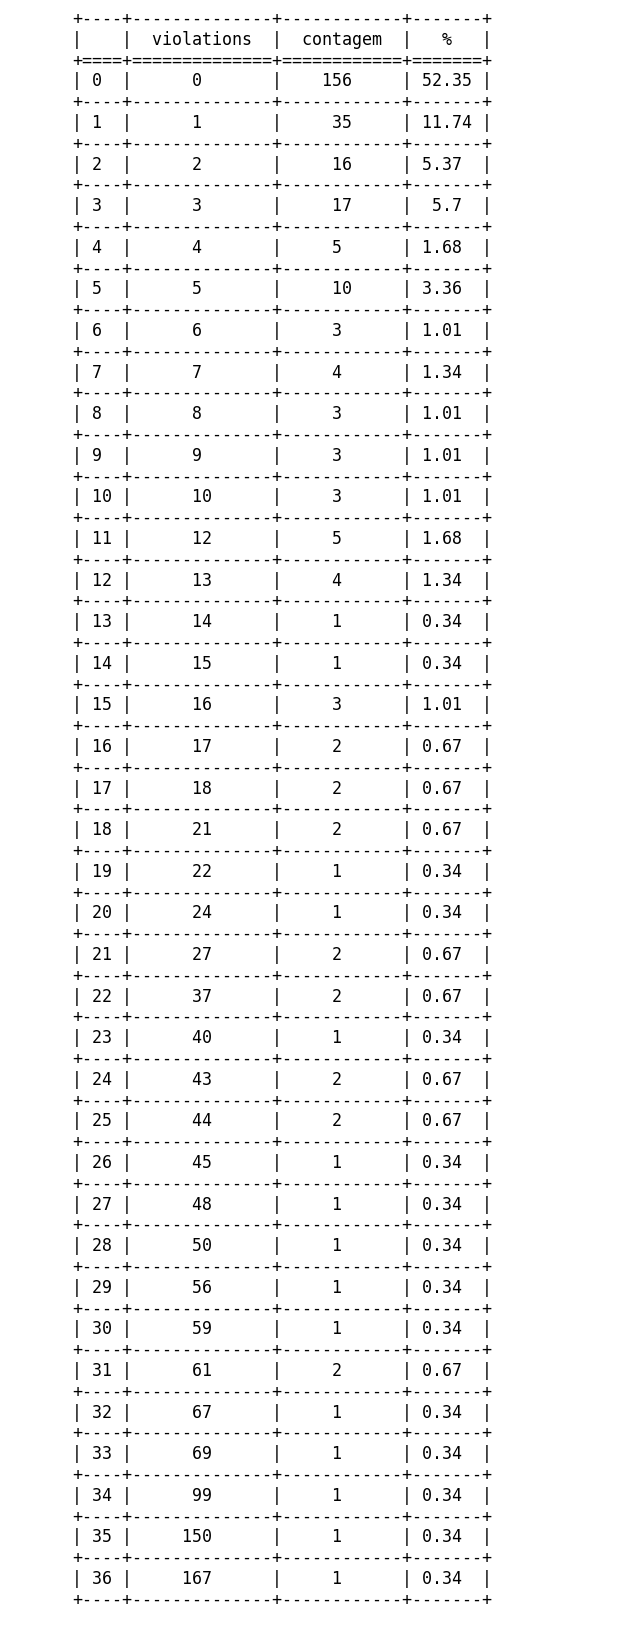

In [31]:
# In[2]: Visualização da tabela de frequências da variável dependente 'violations'
#no ambiente Plots (apenas para fins didáticos)

table.reset_index(level=0, inplace=True)
table.rename(columns={'index': 'n'}, inplace=True)

from tabulate import tabulate
tabela = tabulate(table, headers='keys', tablefmt='grid', numalign='center')

plt.figure(figsize=(8, 3))
plt.text(0.1, 0.1, tabela, {'family': 'monospace', 'size': 12})
plt.axis('off')
plt.show()

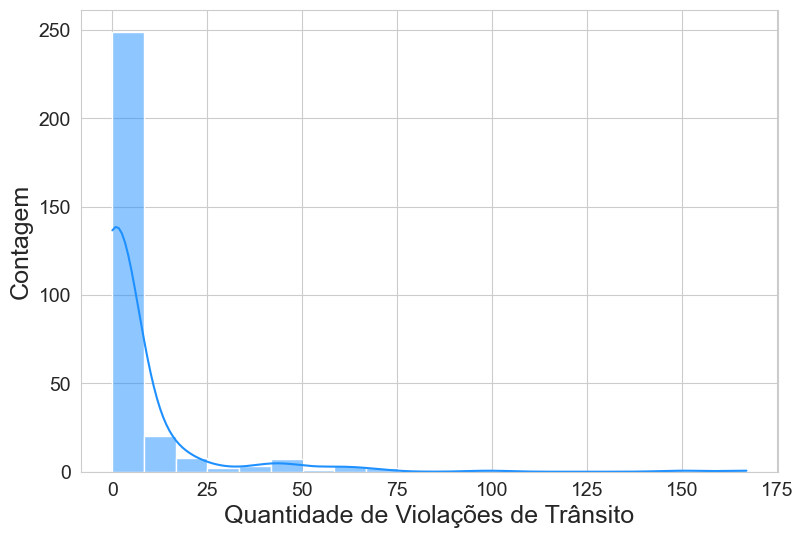

In [32]:
# In[3]: Histograma da variável dependente 'violations'

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(9,6))
    sns.histplot(data=df_corruption, x='violations', bins=20,
                 color='dodgerblue', edgecolor='white', kde=True)
    plt.xlabel('Quantidade de Violações de Trânsito', fontsize=18)
    plt.ylabel('Contagem', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [33]:
# In[4]: Diagnóstico preliminar para observação de eventual igualdade entre a
#média e a variância da variável dependente 'violations'

pd.DataFrame({'Média':[df_corruption.violations.mean()],
              'Variância':[df_corruption.violations.var()]})

,Média,Variância
0,6.496644,331.617834


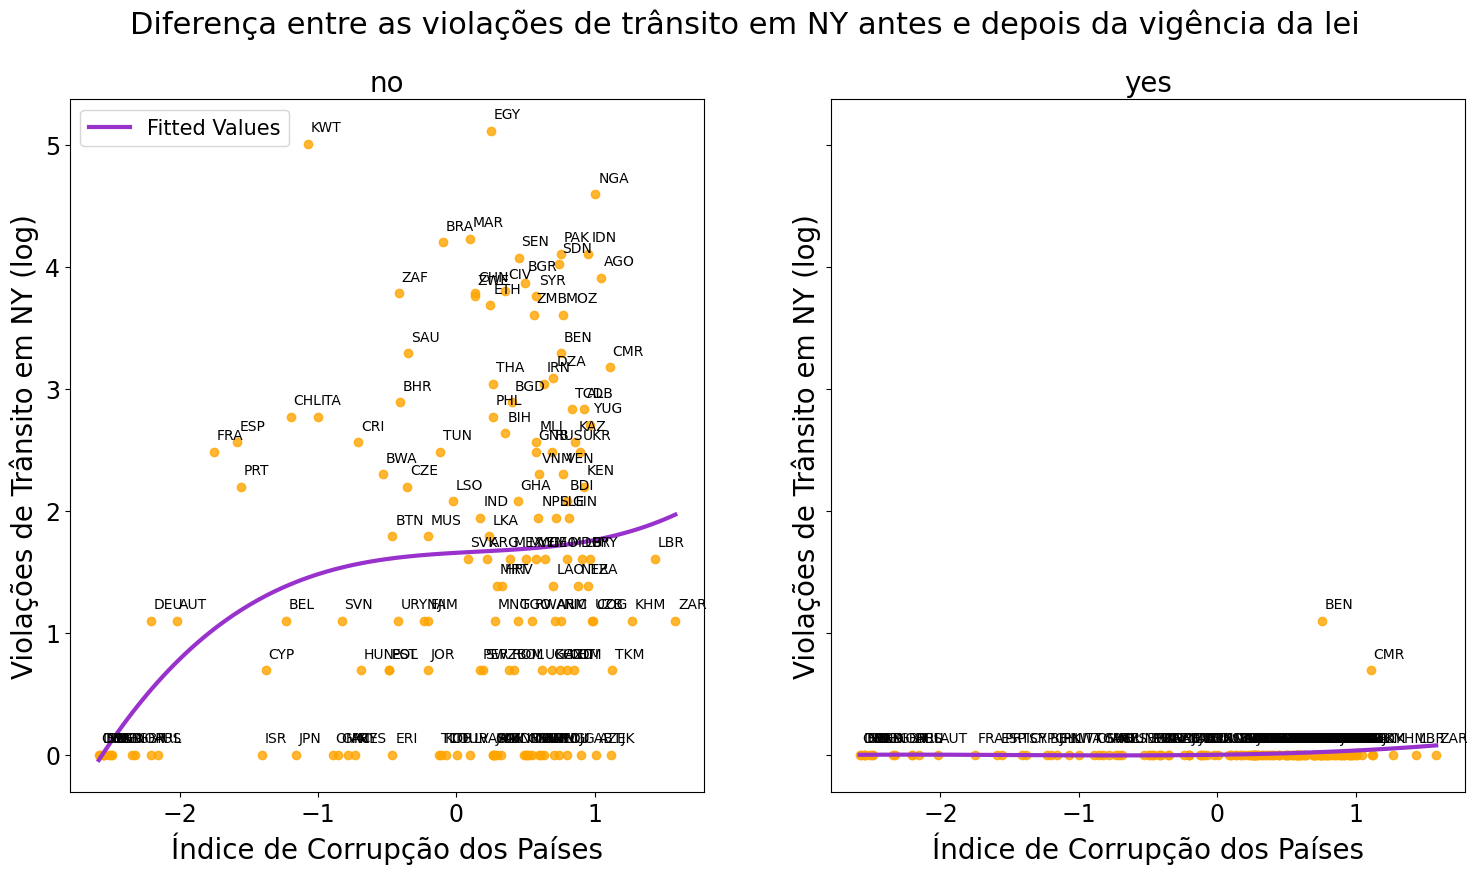

In [34]:
# In[5]: Comportamento das variáveis 'corruption' e 'violations' antes e
#depois do início da vigência da lei

fig, axs = plt.subplots(ncols=2, figsize=(18,9), sharey=True)

fig.suptitle('Diferença entre as violações de trânsito em NY antes e depois da vigência da lei',
             fontsize=22)

post = ['no', 'yes']

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.1, str(point['val']))

for i, v in enumerate(post):
    df = df_corruption[df_corruption.post==v]
    df['violations'] = np.log(df.violations)
    df.loc[df['violations'] == np.inf, 'violations'] = 0
    df.loc[df['violations'] == -np.inf, 'violations'] = 0
    sns.regplot(data=df, x='corruption', y='violations',
                order=3, ax=axs[i], ci=False,
                line_kws={'color':'darkorchid', 'linewidth': 3,
                          'label':'Fitted Values'},
                scatter_kws={'color':'orange'})
    axs[i].set_title(v, fontsize=20)
    axs[i].set_ylabel("Violações de Trânsito em NY (log)", fontsize=20)
    axs[i].set_xlabel("Índice de Corrupção dos Países", fontsize=20)
    label_point(df.corruption, df.violations, df.code, axs[i])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=17)
    
axs[0].legend(loc='upper left', fontsize=15)

plt.show()

In [35]:
# In[6]: Estimação do modelo Poisson

# O argumento 'family=sm.families.Poisson()' da função 'smf.glm' define a
#estimação de um modelo Poisson

modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption',
                         data=df_corruption,
                         family=sm.families.Poisson()).fit()

# Parâmetros do 'modelo_poisson'
print(modelo_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Fri, 27 Sep 2024   Deviance:                       3644.0
Time:                        18:13:18   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      

In [36]:
# In[7]: Outro modo mais completo de apresentar os outputs do modelo,
#pela função 'summary_col'

summary_col([modelo_poisson],
            model_names=["MODELO"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,MODELO
Intercept,2.2127***
,(0.0311)
post[T.yes],-4.2968***
,(0.1974)
staff,0.0219***
,(0.0012)
corruption,0.3418***
,(0.0275)
N,298
Log-lik,-2071.79


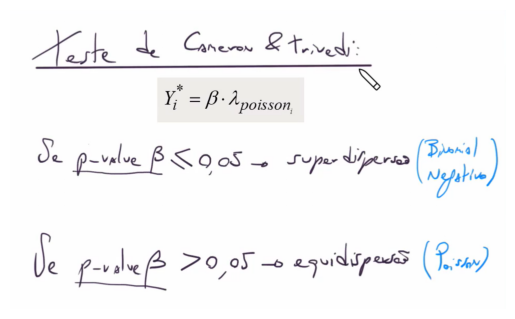

In [37]:
# In[8]: Todas as variáveis preditoras se mostraram estatisticamente
#diferentes de zero, considerando-se um nível de significância de 5%,
#ceteris paribus. Porém, já se pode afirmar que a estimação Poisson é a mais
#adequada?

##############################################################################
#           TESTE DE SUPERDISPERSÃO DE CAMERON E TRIVEDI (1990)              #
##############################################################################
# CAMERON, A. C.; TRIVEDI, P. K. Regression-based tests for overdispersion in
#the Poisson model. Journal of Econometrics, v. 46, n. 3, p. 347-364, 1990.

# 1º Passo: estimar um modelo Poisson;
# 2º Passo: criar uma nova variável (Y*) utilizando os fitted values do modelo
#Poisson estimado anteriormente;
# 3º Passo: estimar um modelo auxiliar OLS, com a variável Y* como variável
#dependente, os fitted values do modelo Poisson como única variável preditora e 
#sem o intercepto;
# 4º Passo: Observar a significância do parâmetro beta.

# Complementar
# Carregar a imagem
img = mpimg.imread('images/output_8.png')

# Exibir a imagem
#plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

In [38]:
# Adicionando os fitted values do modelo Poisson ('lambda_poisson') ao dataframe
df_corruption['lambda_poisson'] = modelo_poisson.fittedvalues
df_corruption.head()

,country,code,violations,staff,post,corruption,lambda_poisson
0,Angola,AGO,50,9,no,1.047506,15.919915
1,Angola,AGO,1,9,yes,1.047506,0.216711
2,Albania,ALB,17,3,no,0.921079,13.371720
3,Albania,ALB,0,3,yes,0.921079,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915


Observe que não é possível capturar a cauda longa com precisão

In [39]:
# Criando a nova variável Y* ('ystar')
df_corruption['ystar'] = (((df_corruption['violations']
                            -df_corruption['lambda_poisson'])**2)
                          -df_corruption['violations'])/df_corruption['lambda_poisson']
df_corruption

,country,code,violations,staff,post,corruption,lambda_poisson,ystar
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915
...,...,...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807,0.243691,0.243691
294,Zambia,ZMB,37,9,no,0.562193,13.486751,38.250347
295,Zambia,ZMB,0,9,yes,0.562193,0.183589,0.183589
296,Zimbabwe,ZWE,43,14,no,0.133379,12.994217,65.979120


In [40]:
# Estimando o modelo auxiliar OLS, sem o intercepto
modelo_auxiliar = sm.OLS.from_formula('ystar ~ 0 + lambda_poisson',
                                      df_corruption).fit()

# Parâmetros do 'modelo_auxiliar'
print(modelo_auxiliar.summary())

# Caso o p-value do parâmetro de lambda_poisson seja maior que 0.05,
# verifica-se a existência de equidispersão nos dados.
# Caso contrário, diagnostica-se a existência de superdispersão nos dados, fato
#que favorecerá a estimação de um modelo binomial negativo, como ocorre nesse
#caso.

                                 OLS Regression Results                                
Dep. Variable:                  ystar   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.584
Date:                Fri, 27 Sep 2024   Prob (F-statistic):                     0.00625
Time:                        18:13:18   Log-Likelihood:                         -1952.9
No. Observations:                 298   AIC:                                      3908.
Df Residuals:                     297   BIC:                                      3911.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [41]:
# In[9]: Função 'overdisp'

# Uma abordagem mais direta para a detecção da superdispersão pelo Teste de
#Cameron e Trivedi (1990) é por meio da utilização da função 'overdisp' do
#pacote 'statstests.tests'

# Instalação e carregamento da função 'overdisp' do pacote 'statstests.tests'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

# Elaboração direta do teste de superdispersão
overdisp(modelo_poisson, df_corruption)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.022    
Dependent Variable:     ystar            AIC:                         3907.7809
Date:                   2024-09-27 18:13 BIC:                         3911.4780
No. Observations:       298              Log-Likelihood:              -1952.9  
Df Model:               1                F-statistic:                 7.584    
Df Residuals:           297              Prob (F-statistic):          0.00625  
R-squared (uncentered): 0.025            Scale:                       28915.   
-------------------------------------------------------------------------------------
            Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
lmbda       2.6525         0.9632       2.7538       0.0063       0.7569       4.5480
-------------

In [42]:
# In[10]: Apenas para fins didáticos, caso considerássemos a estimação Poisson
#como a mais adequada, qual seria a quantidade média esperada de violações
#de trânsito para um país cujo corpo diplomático fosse composto por 23 membros,
#considerando o período anterior à vigência da lei e cujo índice de corrupção
#seja igual a 0.5?

modelo_poisson.predict(pd.DataFrame({'staff':[28],
                                     'post':['no'],
                                     'corruption':[1]}))

0    23.733008
dtype: float64

In [43]:
# Qual seria a quantidade média esperada de violações de trânsito para o mesmo
#país, porém agora considerando a vigência da lei?

modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

In [44]:
# In[BINOMIAL NEGATIVA]:
##############################################################################
#                     A DISTRIBUIÇÃO BINOMIAL NEGATIVA                       #
##############################################################################

# Estabelecendo uma função da distribuição binomial negativa para determinados
#valores de theta e delta
# theta: parâmetro de forma da distribuição Poisson-Gama (binomial negativa)
# delta: parâmetro de taxa de decaimento da distribuição Poisson-Gama

def bneg(theta, delta, m):
    return ((delta ** theta) * (m ** (theta - 1)) * (exp(-m * delta))) / factorial(theta - 1)

# In[Binomial Negativa 1]: Plotagem das funções estabelecidas para diferentes valores de
#theta e delta

m = np.arange(1,21)

bneg_theta2_delta2 = []
bneg_theta3_delta1 = []
bneg_theta3_delta05 = []

for item in m:
    # Estabelecendo a distribuição binomial negativa com theta=2 e delta=2
    bneg_theta2_delta2.append(bneg(2,2,item))
    # Estabelecendo a distribuição binomial negativa com theta=3 e delta=1
    bneg_theta3_delta1.append(bneg(3,1,item))
    # Estabelecendo a distribuição binomial negativa com theta=3 e delta=0.5
    bneg_theta3_delta05.append(bneg(3,0.5,item))

# Criando um dataframe com m variando de 1 a 20 e diferentes valores de
#theta e delta
df_bneg = pd.DataFrame({'m':m,
                        'bneg_theta2_delta2':bneg_theta2_delta2,
                        'bneg_theta3_delta1':bneg_theta3_delta1,
                        'bneg_theta3_delta05':bneg_theta3_delta05})

df_bneg.head(2)

,m,bneg_theta2_delta2,bneg_theta3_delta1,bneg_theta3_delta05
0,1,0.541341,0.183940,0.037908
1,2,0.146525,0.270671,0.091970


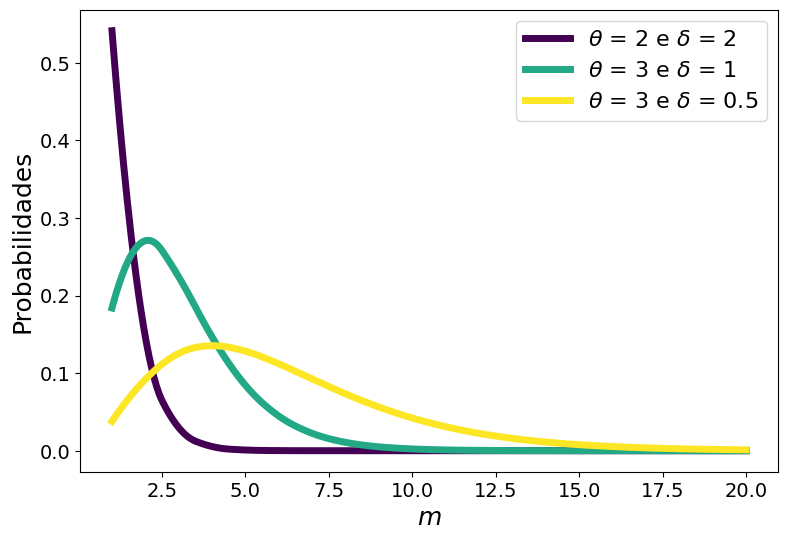

In [45]:
# In[Binomial Negativa 2]: Plotagem propriamente dita

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, bneg_theta2_delta2 = smooth_line_plot(df_bneg.m,
                                             df_bneg.bneg_theta2_delta2)
x_new, bneg_theta3_delta1 = smooth_line_plot(df_bneg.m,
                                             df_bneg.bneg_theta3_delta1)
x_new, bneg_theta3_delta05 = smooth_line_plot(df_bneg.m,
                                              df_bneg.bneg_theta3_delta05)

plt.figure(figsize=(9,6))
plt.plot(x_new,bneg_theta2_delta2, linewidth=5, color='#440154FF')
plt.plot(x_new,bneg_theta3_delta1, linewidth=5, color='#22A884FF')
plt.plot(x_new,bneg_theta3_delta05, linewidth=5, color='#FDE725FF')
plt.xlabel('m', fontsize=18, style='italic')
plt.ylabel('Probabilidades', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([r'$\theta$ = 2 e $\delta$ = 2',
            r'$\theta$ = 3 e $\delta$ = 1',
            r'$\theta$ = 3 e $\delta$ = 0.5'],
           fontsize=16)
plt.show()

In [46]:
# In[11]: Estimação do modelo binomial negativo do tipo NB2

# O argumento 'family=sm.families.NegativeBinomial(alpha=2.0963)' da função
#'smf.glm' define a estimação de um modelo binomial negativo do tipo NB2
#com valor de 'fi' ('alpha' no Python) igual a 2.0963 (valor proveniente da
#estimação realizada por meio do Solver do Excel). Lembramos que 'fi' é o
#inverso do parâmetro de forma 'theta' da distribuição Poisson-Gama.

modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption,
                      family=sm.families.NegativeBinomial(alpha=2.0963)).fit() # atenção parâmetro alpha, obtenção do valor na próxima célula

# Parâmetros do 'modelo_bneg'
print(modelo_bneg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Fri, 27 Sep 2024   Deviance:                       239.13
Time:                        18:13:19   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6714
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9469      0.162     12.050      

In [47]:
# In[12]: Construção de uma função para a definição do 'fi' ótimo (argumento 'alpha')
# que gera a maximização do valor de Log-Likelihood

# Tempo aproximado de estimação desta célula: 1 min 40 seg

n_samples = 10000
alphas = np.linspace(0, 10, n_samples)
llf = np.full(n_samples, fill_value=np.nan)

for i, alpha in tqdm(enumerate(alphas), total=n_samples, desc='Estimating'):
    try:
        model = smf.glm(formula='violations ~ staff + post + corruption',
                        data=df_corruption,
                        family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    except:
        continue
    llf[i] = model.llf

fi_ótimo = alphas[np.nanargmax(llf)].round(4)
fi_ótimo

Estimating: 100%|██████████| 10000/10000 [01:31<00:00, 109.50it/s]


2.0962

ATENÇÃO!!! Na prática, usar forma mais direta para estimação do modelo (VER script_complementar_bin_neg.ipynb) 

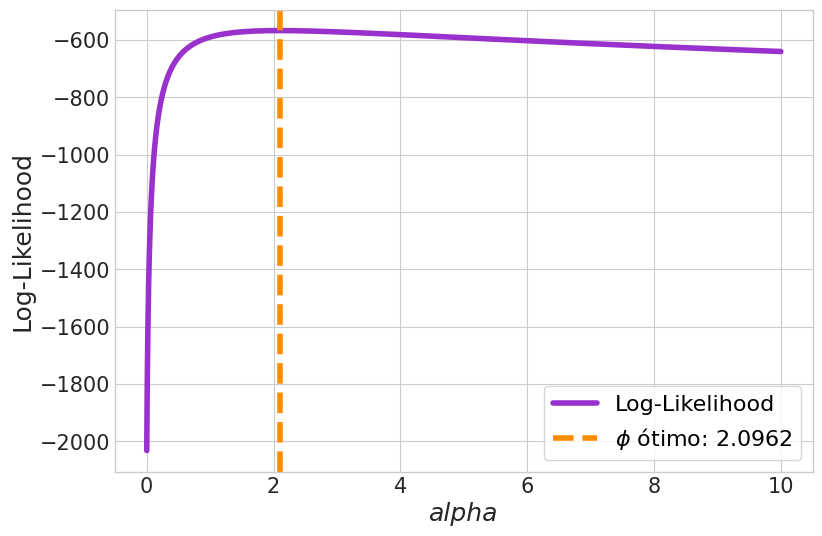

In [48]:
# In[13]: Plotagem dos resultados (Log-likelihood x fi)

plt.figure(figsize=(9, 6))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(alphas, llf, label='Log-Likelihood', color='darkorchid', linewidth = 4)
    plt.axvline(x=fi_ótimo, color='darkorange', linewidth = 4, linestyle='dashed',
            label=f'$\phi$ ótimo: {round(fi_ótimo, 4)}')
plt.xlabel('alpha', fontsize=18, style='italic')
plt.ylabel('Log-Likelihood', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [49]:
# In[14]: Reestimação do modelo binomial negativo com o parâmetro 'fi_ótimo'

modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption,
                      family=sm.families.NegativeBinomial(alpha=fi_ótimo)).fit()

# Parâmetros do 'modelo_bneg'
print(modelo_bneg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Fri, 27 Sep 2024   Deviance:                       239.14
Time:                        18:14:50   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6714
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9469      0.162     12.050      

In [50]:
# In[15]: Comparando os modelos Poisson e binomial negativo

summary_col([modelo_poisson, modelo_bneg], 
            model_names=["Poisson","BNeg"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
                })

,Poisson,BNeg
Intercept,2.2127***,1.9469***
,(0.0311),(0.1616)
post[T.yes],-4.2968***,-4.2746***
,(0.1974),(0.2660)
staff,0.0219***,0.0400***
,(0.0012),(0.0089)
corruption,0.3418***,0.4527***
,(0.0275),(0.1146)
N,298,298
Log-lik,-2071.79,-567.40


Mudar a classe do modelo muda a significância das variáveis.

In [51]:
# In[16]: Definição da função para realização do teste de razão de verossimilhança

# Definição da função 'lrtest'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [52]:
# In[17]: Teste de de razão de verossimilhança para comparar as estimações dos
#'modelo_poisson' e 'modelo_bneg'

lrtest([modelo_poisson, modelo_bneg])

Likelihood Ratio Test:
-2.(LL0-LLm): 3008.79
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


In [53]:
# In[18]: Gráfico para a comparação dos LogLiks dos modelos Poisson e
#binomial negativo

# Definição do dataframe com os modelos e respectivos LogLiks
df_llf = pd.DataFrame({'modelo':['Poisson','BNeg'],
                      'loglik':[modelo_poisson.llf, modelo_bneg.llf]})
df_llf

,modelo,loglik
0,Poisson,-2071.793753
1,BNeg,-567.401172


Melhor o LogLik mais alto (BNeg)

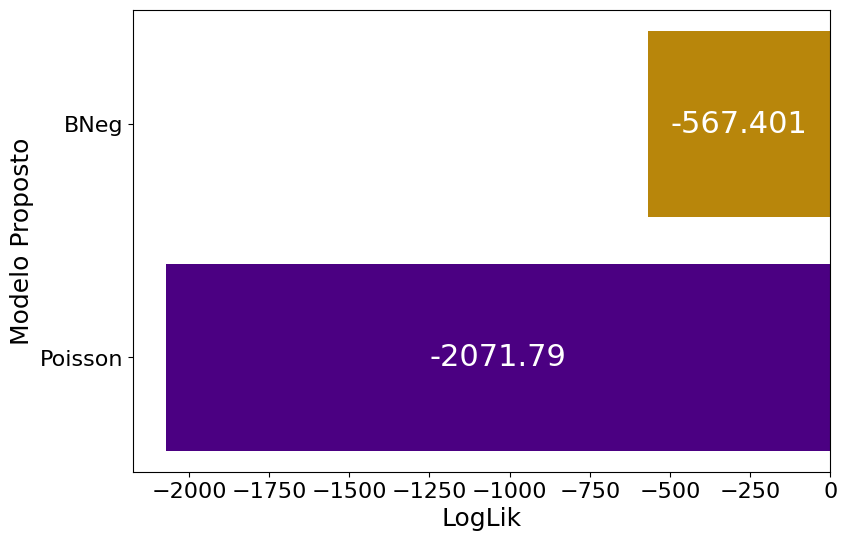

In [54]:
# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(9,6))

c = ['indigo', 'darkgoldenrod']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize=18)
ax.set_xlabel("LogLik", fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
plt.show()

In [55]:
# # In[19]: Gráfico para a comparação dos LogLiks dos modelos Poisson e
# #binomial negativo, com JPG para fins didáticos

# # Define a URL da imagem
# url = "https://i.pinimg.com/474x/80/9b/40/809b40f1c99aec99cccbb53d0dc587c5.jpg"

# # Carrega a imagem da URL
# imagem = Image.open(urllib.request.urlopen(url))

# # Define as dimensões e a posição desejada da imagem
# nova_largura = 2000  # Largura da imagem redimensionada
# nova_altura = 2000   # Altura da imagem redimensionada
# posicao_x = 4500       # Posição horizontal da imagem
# posicao_y = 3600       # Posição vertical da imagem

# # Redimensiona a imagem
# imagem_redimensionada = imagem.resize((nova_largura, nova_altura))

# # Definição do dataframe com os modelos e respectivos LogLiks
# df_llf = pd.DataFrame({'modelo': ['Poisson', 'BNeg'],
#                        'loglik': [modelo_poisson.llf, modelo_bneg.llf]})

# # Plotagem propriamente dita
# fig, ax = plt.subplots(figsize=(15, 10))

# c = ['indigo', 'darkgoldenrod']

# ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color=c)
# ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
# ax.set_ylabel("Modelo Proposto", fontsize=20)
# ax.set_xlabel("LogLik", fontsize=20)
# ax.tick_params(axis='y', labelsize=20)
# ax.tick_params(axis='x', labelsize=20)

# # Adiciona a imagem redimensionada em uma posição específica do gráfico
# plt.figimage(imagem_redimensionada, posicao_x, posicao_y, zorder=1, alpha=0.73)

# # Exibe o gráfico com a imagem
# plt.show()

In [56]:
# In[20]: COMPARAÇÕES ENTRE AS PREVISÕES:

# Qual seria a quantidade média esperada de violações de trânsito para um país
#cujo corpo diplomático seja composto por 23 membros, considerando o período
#anterior à vigência da lei e cujo índice de corrupção seja igual 0.5?

# Modelo Poisson:

modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))

0    17.93284
dtype: float64

In [57]:
# Modelo binomial negativo:

modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                  'post':['no'],
                                  'corruption':[0.5]}))

0    22.057246
dtype: float64

In [58]:
# In[21]: COMPARAÇÕES ENTRE AS PREVISÕES (continuação):

# Qual seria a quantidade média esperada de violações de trânsito para o mesmo
#país, porém agora considerando a vigência da lei?

# Modelo Poisson:
    
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

In [59]:
# Modelo binomial negativo:

modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                  'post':['yes'],
                                  'corruption':[0.5]}))


0    0.306974
dtype: float64

In [60]:
# In[22]: Adicionando os fitted values dos modelos estimados até o momento,
#para fins de comparação

# Modelo Poisson:
df_corruption['fitted_poisson'] = modelo_poisson.fittedvalues

# Modelo binomial negativo:
df_corruption['fitted_bneg'] = modelo_bneg.fittedvalues

# Visualização do dataframe com os fitted values do modelos estimados
df_corruption[['country','code','violations','fitted_poisson','fitted_bneg']]

,country,code,violations,fitted_poisson,fitted_bneg
0,Angola,AGO,50,15.919915,16.138592
1,Angola,AGO,1,0.216711,0.224603
2,Albania,ALB,17,13.371720,11.987630
3,Albania,ALB,0,0.182023,0.166834
4,United Arab Emirates,ARE,0,7.477915,5.551770
...,...,...,...,...,...
293,Zaire,ZAR,0,0.243691,0.253810
294,Zambia,ZMB,37,13.486751,12.955688
295,Zambia,ZMB,0,0.183589,0.180306
296,Zimbabwe,ZWE,43,12.994217,13.033499


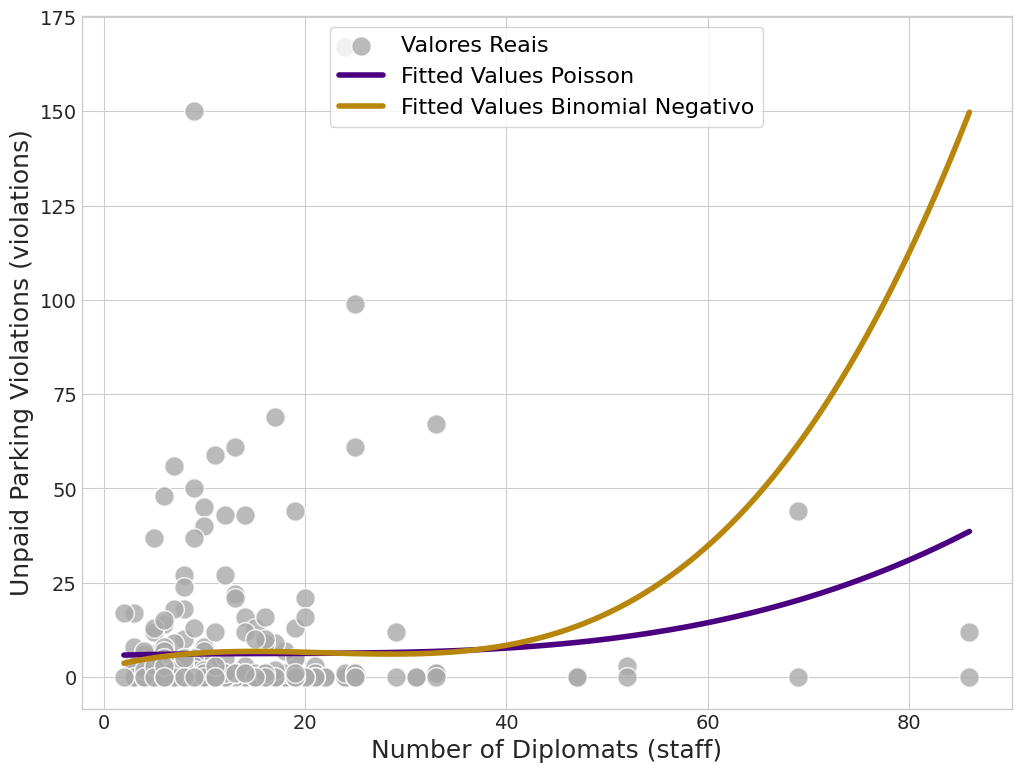

In [61]:
# In[23]: Fitted values dos modelos Poisson e binomial negativo, considerando,
#para fins didáticos, apenas a variável preditora 'staff'

plt.figure(figsize=(12,9))
with plt.style.context('seaborn-v0_8-whitegrid'):
    sns.scatterplot(x='staff', y='violations', data=df_corruption, color='darkgrey',
                s=200, label='Valores Reais', alpha=0.8)
    sns.regplot(data=df_corruption, x='staff', y='fitted_poisson', order=3, ci=False,
            scatter=False, color='indigo',
            label='Fitted Values Poisson',
            line_kws={'linewidth': 4})
    sns.regplot(data=df_corruption, x='staff', y='fitted_bneg', order=3, ci=False,
            scatter = False, color='darkgoldenrod',
            label='Fitted Values Binomial Negativo',
            line_kws={'linewidth': 4})
plt.xlabel('Number of Diplomats (staff)', fontsize=18)
plt.ylabel('Unpaid Parking Violations (violations)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', fontsize=16)
plt.show()

In [62]:
# In[24]:
##############################################################################
#     ESTIMAÇÕES MUITO PRÓXIMAS PARA POISSON E BNEG SEM SUPERDISPERSÃO!      #
##############################################################################

# Para fins didáticos, vamos gerar novo dataframe 'df_corruption2', com quantidades
#de violações de trânsito iguais, no máximo, a 3. Este procedimento poderá,
#eventualmente, eliminar o fenômeno da superdispersão nos dados da variável
#dependente e, consequentemente, tornar as estimações dos modelos POISSON e
#BINOMIAL NEGATIVO praticamente iguais.

# Gerando novo dataframe ('df_corruption2') com seleção das variáveis originais
df_corruption2 = df_corruption.iloc[:, 0:6]

# Seleção das observações com 'violations' menores ou iguais a 3
df_corruption2 = df_corruption2[df_corruption2['violations'] <= 3]

# Visualização do dataframe 'df_corruption2'
df_corruption2

,country,code,violations,staff,post,corruption
1,Angola,AGO,1,9,yes,1.047506
3,Albania,ALB,0,3,yes,0.921079
4,United Arab Emirates,ARE,0,3,no,-0.779468
5,United Arab Emirates,ARE,0,3,yes,-0.779468
7,Argentina,ARG,0,19,yes,0.223567
...,...,...,...,...,...,...
291,South Africa,ZAF,1,19,yes,-0.415147
292,Zaire,ZAR,3,6,no,1.582807
293,Zaire,ZAR,0,6,yes,1.582807
295,Zambia,ZMB,0,9,yes,0.562193


In [63]:
# Características do dataframe (224 observações)
df_corruption2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 1 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     224 non-null    object 
 1   code        224 non-null    object 
 2   violations  224 non-null    int64  
 3   staff       224 non-null    int64  
 4   post        224 non-null    object 
 5   corruption  224 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 12.2+ KB


In [64]:
# Estatísticas univariadas (note que o valor máximo de ocorrências na variável
#'violations' agora é 3)
df_corruption2.describe()

,violations,staff,corruption
count,224.000000,224.000000,224.000000
mean,0.526786,11.415179,-0.085940
std,0.922658,10.509101,1.085816
min,0.000000,2.000000,-2.582988
25%,0.000000,5.000000,-0.499298
50%,0.000000,9.000000,0.279324
75%,1.000000,14.000000,0.702910
max,3.000000,86.000000,1.582807


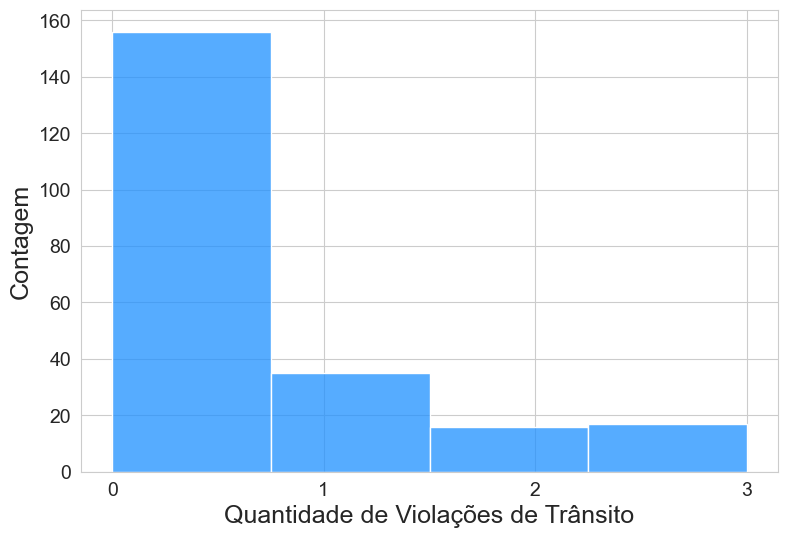

In [65]:
# In[25]: Histograma da variável dependente 'violations' no dataframe 'df_corruption2'

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(9,6))
    sns.histplot(data=df_corruption2, x='violations', bins=4,
                 color='dodgerblue', edgecolor='white', kde=False)
    plt.xlabel('Quantidade de Violações de Trânsito', fontsize=18)
    plt.ylabel('Contagem', fontsize=18)
    plt.xticks(range(4), fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [66]:
# In[26]: Diagnóstico preliminar para observação de eventual igualdade entre
#a média e a variância da variável dependente 'violations' no dataframe
#'df_corruption2'

pd.DataFrame({'Média':[df_corruption2['violations'].mean()],
              'Variância':[df_corruption2['violations'].var()]})

,Média,Variância
0,0.526786,0.851297


In [67]:
# In[27]: Estimação do 'modelo_poisson2'

modelo_poisson2 = smf.glm(formula='violations ~ staff + post + corruption',
                          data=df_corruption2,
                          family=sm.families.Poisson()).fit()

# Parâmetros do 'modelo_poisson2'
print(modelo_poisson2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  224
Model:                            GLM   Df Residuals:                      220
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -179.47
Date:                Fri, 27 Sep 2024   Deviance:                       196.25
Time:                        18:14:51   Pearson chi2:                     243.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3919
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1322      0.145      0.909      

In [68]:
# In[28]: Teste de superdispersão no dataset 'corruption2'

# Função 'overdisp'
# Instalação e carregamento da função 'overdisp' do pacote 'statstests.tests'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

# Elaboração direta do teste de superdispersão
overdisp(modelo_poisson2, df_corruption2)

Estimating model...: 
 GLM
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): -0.004  
Dependent Variable:     ystar            AIC:                         899.5607
Date:                   2024-09-27 18:14 BIC:                         902.9724
No. Observations:       224              Log-Likelihood:              -448.78 
Df Model:               1                F-statistic:                 0.1004  
Df Residuals:           223              Prob (F-statistic):          0.752   
R-squared (uncentered): 0.000            Scale:                       3.2335  
-----------------------------------------------------------------------------------
              Coef.       Std.Err.        t         P>|t|        [0.025      0.975]
-----------------------------------------------------------------------------------
lmbda         0.0500        0.1577      0.3169      0.7516      -0.2607      0.3607
-----------------------------

Não há superdispersão 

In [69]:
# In[29]: Estimação do modelo binomial negativo ('modelo_bneg2') no dataframe
#'df_corruption2'

n_samples = 1000
alphas = np.linspace(0, 10, n_samples)
llf = np.full(n_samples, fill_value=np.nan)

for i, alpha in tqdm(enumerate(alphas), total=n_samples, desc='Estimating'):
    try:
        model = smf.glm(formula='violations ~ staff + post + corruption',
                        data=df_corruption2,
                        family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    except:
        continue
    llf[i] = model.llf

fi_ótimo2 = alphas[np.nanargmax(llf)].round(4)
fi_ótimo2

Estimating: 100%|██████████| 1000/1000 [00:07<00:00, 135.31it/s]


0.0901

In [70]:
# Estimação propriamente dita do 'modelo_bneg2'

modelo_bneg2 = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption2,
                      family=sm.families.NegativeBinomial(alpha=fi_ótimo2)).fit()

# Parâmetros do 'modelo_bneg2'
print(modelo_bneg2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  224
Model:                            GLM   Df Residuals:                      220
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -179.33
Date:                Fri, 27 Sep 2024   Deviance:                       186.10
Time:                        18:14:59   Pearson chi2:                     232.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3767
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1243      0.151      0.824      

In [71]:
# In[30]: Comparando os parâmetros e os valores de LogLiks dos 'modelo_poisson2'
#e 'modelo_bneg2'

summary_col([modelo_poisson2, modelo_bneg2], 
            model_names=["Poisson","BNeg"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
                })

,Poisson,BNeg
Intercept,0.1322,0.1243
,(0.1453),(0.1510)
post[T.yes],-2.0552***,-2.0603***
,(0.2256),(0.2306)
staff,0.0100,0.0109
,(0.0100),(0.0102)
corruption,0.3562***,0.3619***
,(0.1048),(0.1085)
N,224,224
Log-lik,-179.47,-179.33


In [72]:
# In[31]: Definição da função para realização do teste de razão de verossimilhança

# Definição da função 'lrtest' (já definida anteriormente neste código)

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [73]:
# In[32]: Teste de de razão de verossimilhança para comparar as estimações dos
#'modelo_poisson2' e 'modelo_bneg2'

lrtest([modelo_poisson2, modelo_bneg2])

# Quando não há superdispersão, não existem diferenças significantes entre os
#modelos Poisson e binomial negativo!

Likelihood Ratio Test:
-2.(LL0-LLm): 0.28
p-value: 0.596

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


Confirmado que, sem o fenômeno de superdispersão, as estimações dos modelos POISSON e BINOMIAL NEGATIVO são praticamente iguais.

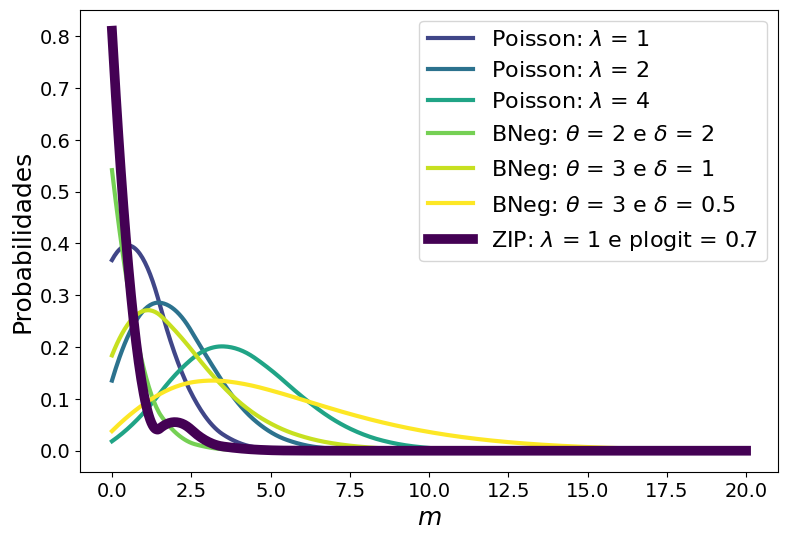

In [74]:
# In[ZIP]:
##############################################################################
#       A DISTRIBUIÇÃO ZERO-INFLATED POISSON (ZIP) - PARTE CONCEITUAL        #
##############################################################################

# LAMBERT, D. Zero-inflated Poisson regression, with an application to defects
#in manufacturing. Technometrics, v. 34, n. 1, p. 1-14, 1992.

# Exemplo de uma função da distribuição ZI Poisson, com lambda=1 e plogit=0,7
def zip_lambda1_plogit07(m):
    lmbda = 1
    plogit = 0.7
    
    if m == 0:
        return (plogit) + ((1 - plogit) * exp(-lmbda))
    else:
        return (1 - plogit) * ((exp(-lmbda) * lmbda ** m) / factorial(m))
      
# In[ZIP 1]: Criando um dataframe ('df_zip') com m variando de 0 a 20

m = np.arange(0,21)

zip_lambda1_plogit07 = [zip_lambda1_plogit07(i) for i in m]

df_zip = pd.DataFrame({'m':m,
                       'zip_lambda1_plogit07':zip_lambda1_plogit07})
#df_zip.head(3)

# In[ZIP 2]: Gráfico para comparar as distribuições Poisson, BNeg e ZIP

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, zip_lambda1_plogit07 = smooth_line_plot(df_zip.m,
                                               df_zip.zip_lambda1_plogit07)

plt.figure(figsize=(9,6))
plt.plot(x_new,lambda_1, linewidth=3, color='#404688FF')
plt.plot(x_new,lambda_2, linewidth=3, color='#2C728EFF')
plt.plot(x_new,lambda_4, linewidth=3, color='#20A486FF')
plt.plot(x_new,bneg_theta2_delta2, linewidth=3, color='#75D054FF')
plt.plot(x_new,bneg_theta3_delta1, linewidth=3, color='#C7E020FF')
plt.plot(x_new,bneg_theta3_delta05, linewidth=3, color='#FDE725FF')
plt.plot(x_new,zip_lambda1_plogit07, linewidth=7, color="#440154FF")
plt.xlabel('m', fontsize=18, style='italic')
plt.ylabel('Probabilidades', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([r'Poisson: $\lambda$ = 1',
            r'Poisson: $\lambda$ = 2',
            r'Poisson: $\lambda$ = 4',
            r'BNeg: $\theta$ = 2 e $\delta$ = 2',
            r'BNeg: $\theta$ = 3 e $\delta$ = 1',
            r'BNeg: $\theta$ = 3 e $\delta$ = 0.5',
            r'ZIP: $\lambda$ = 1 e plogit = 0.7'],
           fontsize=16)
plt.show()

In [75]:
# In[33]:
##############################################################################
#              ESTIMAÇÃO DO MODELO ZERO-INFLATED POISSON (ZIP)               #
##############################################################################

# Estimação do modelo ZIP pela função 'ZeroInflatedPoisson' do pacote
#'statsmodels.discrete.count_model'

# Definição da variável dependente (voltando ao dataset 'df_corruption')
y = df_corruption['violations']

# Definição das variáveis preditoras que entrarão no componente de contagem
x1 = df_corruption[['staff','post','corruption']]
X1 = sm.add_constant(x1)

# Dummização da variável 'post'
# Se estimarmos o modelo sem dummizar as variáveis categóricas, o modelo retorna
#um erro
X1 = pd.get_dummies(X1, columns=['post'], dtype=int, drop_first=True)

# Definição das variáveis preditoras que entrarão no componente logit (inflate)
x2 = df_corruption[['corruption']]
X2 = sm.add_constant(x2)

# O argumento 'exog_infl' corresponde às variáveis que entram no componente
#logit (inflate)
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2,
                                    inflation='logit').fit()

# Parâmetros do 'modelo_zip'
print(modelo_zip.summary())

Optimization terminated successfully.
         Current function value: 5.977545
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:              violations   No. Observations:                  298
Model:             ZeroInflatedPoisson   Df Residuals:                      294
Method:                            MLE   Df Model:                            3
Date:                 Fri, 27 Sep 2024   Pseudo R-squ.:                  0.1975
Time:                         18:14:59   Log-Likelihood:                -1781.3
converged:                        True   LL-Null:                       -2219.8
Covariance Type:             nonrobust   LLR p-value:                8.828e-190
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const 

Os modelos de regressão Poisson inflacionados de zeros apresentam dois processos geradores de zeros, sendo um devido à distribuição binária (neste caso, são gerados os chamados zeros estruturais) e outro devido à distribuição Poisson (nesta situação, são gerados dados de contagem, entre os quais os chamados zeros amostrais).

In [76]:
# In[34]: Teste de Vuong

# VUONG, Q. H. Likelihood ratio tests for model selection and non-nested
#hypotheses. Econometrica, v. 57, n. 2, p. 307-333, 1989.

# Definição de função para elaboração do teste de Vuong
# Autores: Luiz Paulo Fávero e Helder Prado Santos

def vuong_test(m1, m2):

    from scipy.stats import norm    

    if m1.__class__.__name__ == "GLMResultsWrapper":
        
        glm_family = modelo_poisson.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()
            
        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]
    
    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")
        
    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")
    
    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")
        
    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))        

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]    
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

In [77]:
# In[35]: Teste de Vuong propriamente dito para verificação de existência de
#inflação de zeros no modelo ZIP, em comparação com o modelo Poisson

vuong_test(modelo_poisson, modelo_zip)

# Ocorrência de inflação de zeros!

Optimization terminated successfully.
         Current function value: 6.952328
         Iterations 9
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -2.993
p-value: 0.001

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [78]:
# In[36]: Comparando os modelos Poisson e ZIP

summary_col([modelo_poisson, modelo_zip], 
            model_names=["Poisson","ZIP"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
                })

,Poisson,ZIP
Intercept,2.2127***,
,(0.0311),
const,,2.4889***
,,(0.0315)
corruption,0.3418***,0.0937***
,(0.0275),(0.0300)
inflate_const,,-1.6116***
,,(0.2401)
inflate_corruption,,-0.9523***
,,(0.1954)


In [79]:
# In[37]: Definição da função para realização do teste de razão de verossimilhança

# Definição da função 'lrtest'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 2) # 2 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [80]:
# In[38]: Teste de de razão de verossimilhança para comparar as estimações dos
#'modelo_poisson' e 'modelo_zip'

lrtest([modelo_poisson, modelo_zip])

Likelihood Ratio Test:
-2.(LL0-LLm): 580.97
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


In [81]:
# In[39]: Gráfico para a comparação dos LogLiks dos modelos Poisson,
#binomial negativo e ZIP

# Definição do dataframe com os modelos e respectivos LogLiks
df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_bneg.llf]})
df_llf

,modelo,loglik
0,Poisson,-2071.793753
1,ZIP,-1781.308425
2,BNeg,-567.401172


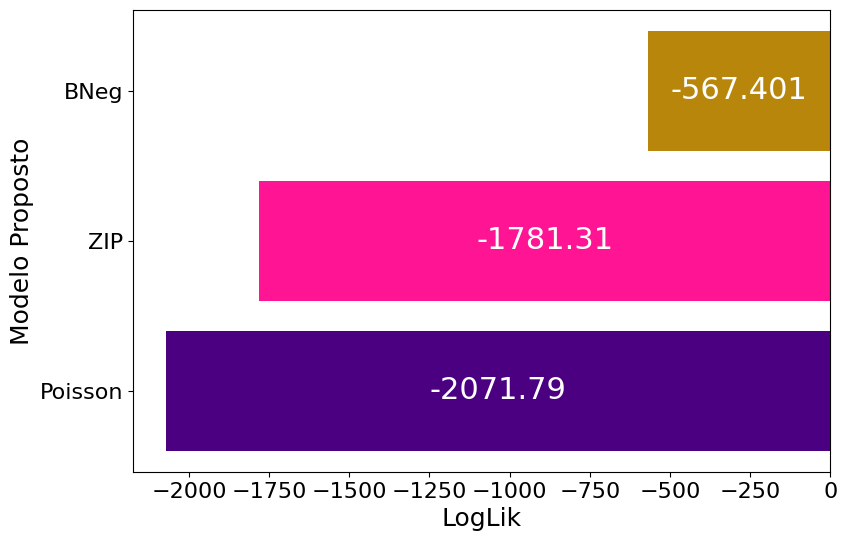

In [82]:
# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(9,6))

c = ['indigo', 'deeppink', 'darkgoldenrod']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize=18)
ax.set_xlabel("LogLik", fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
plt.show()

In [83]:
# In[ZINB]:
##############################################################################
#  A DISTRIBUIÇÃO ZERO-INFLATED BINOMIAL NEGATIVA (ZINB) - PARTE CONCEITUAL  #
##############################################################################

# Exemplo de uma função da distribuição ZI Binomial Negativa, com theta = 2,
#delta = 2, plogit = 0.7 e lambda_bneg = 2
def zinb_theta2_delta2_plogit07_lambda2(m):
    lambda_bneg = 1
    plogit = 0.7
    theta = 2
    delta = 2
    if m == 0:
        return (plogit) + ((1 - plogit) *
                           (((1) / (1 + 1/theta * lambda_bneg)) ** theta))
    else:
        return (1 - plogit) * ((delta ** theta) * (m ** (theta - 1)) *
                               (exp(-m * delta))) / factorial(theta - 1)

In [84]:
# In[ZINB 1]: Criando um dataframe ('df_zinb') com m variando de 0 a 20

m = np.arange(0,21)

zinb_theta2_delta2_plogit07_lambda2 = [zinb_theta2_delta2_plogit07_lambda2(i)
                                       for i in m]

df_zinb = pd.DataFrame({'m':m,
                       'zinb_theta2_delta2_plogit07_lambda2':zinb_theta2_delta2_plogit07_lambda2})
df_zinb

,m,zinb_theta2_delta2_plogit07_lambda2
0,0,8.333333e-01
1,1,1.624023e-01
2,2,4.395753e-02
3,3,8.923508e-03
4,4,1.610221e-03
5,5,2.723996e-04
6,6,4.423833e-05
7,7,6.984841e-06
8,8,1.080338e-06
9,9,1.644838e-07


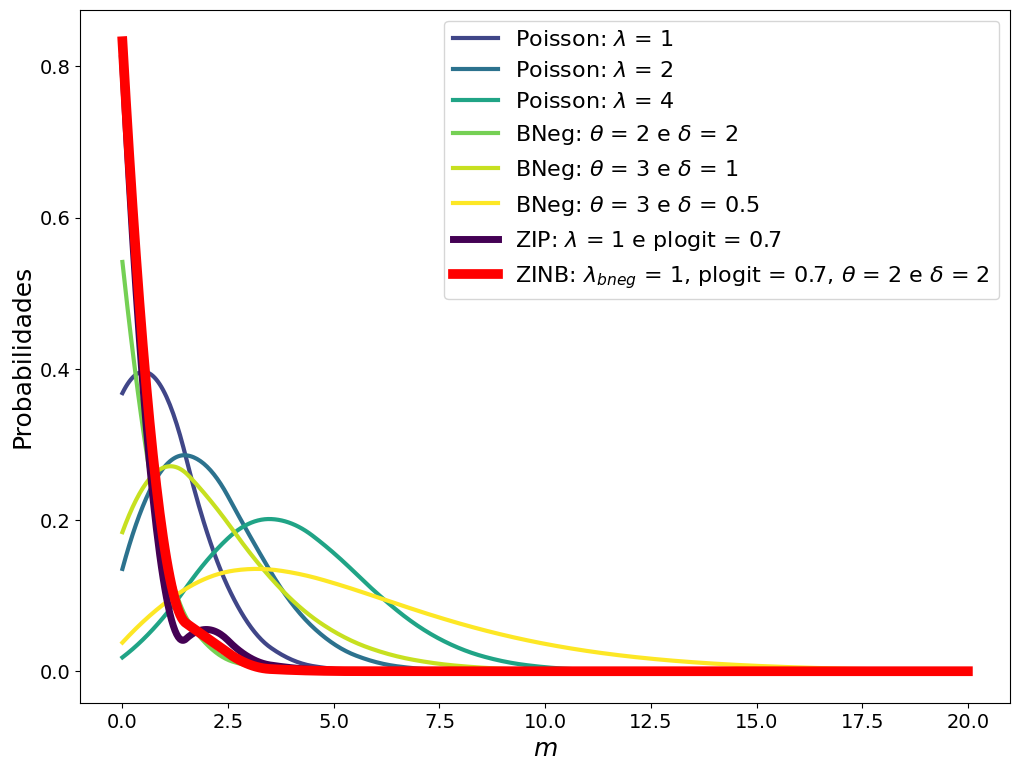

In [85]:
# In[ZINB 2]: Gráfico para comparar as distribuições Poisson, BNeg, ZIP e ZINB

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, zinb_theta2_delta2_plogit07_lambda2 = smooth_line_plot(df_zinb.m,
                                                              df_zinb.zinb_theta2_delta2_plogit07_lambda2)

plt.figure(figsize=(12,9))
plt.plot(x_new,lambda_1, linewidth=3, color='#404688FF')
plt.plot(x_new,lambda_2, linewidth=3, color='#2C728EFF')
plt.plot(x_new,lambda_4, linewidth=3, color='#20A486FF')
plt.plot(x_new,bneg_theta2_delta2, linewidth=3, color='#75D054FF')
plt.plot(x_new,bneg_theta3_delta1, linewidth=3, color='#C7E020FF')
plt.plot(x_new,bneg_theta3_delta05, linewidth=3, color='#FDE725FF')
plt.plot(x_new,zip_lambda1_plogit07, linewidth=5, color="#440154FF")
plt.plot(x_new,zinb_theta2_delta2_plogit07_lambda2, linewidth=7, color="red")
plt.xlabel('m', fontsize=18, style='italic')
plt.ylabel('Probabilidades', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([r'Poisson: $\lambda$ = 1',
            r'Poisson: $\lambda$ = 2',
            r'Poisson: $\lambda$ = 4',
            r'BNeg: $\theta$ = 2 e $\delta$ = 2',
            r'BNeg: $\theta$ = 3 e $\delta$ = 1',
            r'BNeg: $\theta$ = 3 e $\delta$ = 0.5',
            r'ZIP: $\lambda$ = 1 e plogit = 0.7',
            r'ZINB: $\lambda$$_{bneg}$ = 1, plogit = 0.7, $\theta$ = 2 e $\delta$ = 2'],
           fontsize=16)
plt.show()

In [86]:
# In[40]:
##############################################################################
#        ESTIMAÇÃO DO MODELO ZERO-INFLATED BINOMIAL NEGATIVO (ZINB)          #
##############################################################################

# Estimação do modelo ZINB pela função 'ZeroInflatedNegativeBinomialP' do pacote
#'statsmodels.discrete.count_model'

# Definição da variável dependente (voltando ao dataset 'df_corruption')
y = df_corruption['violations']

# Definição das variáveis preditoras que entrarão no componente de contagem
x1 = df_corruption[['staff','post','corruption']]
X1 = sm.add_constant(x1)

# Dummização da variável 'post'
# Se estimarmos o modelo sem dummizar as variáveis categóricas, o modelo retorna
#um erro
X1 = pd.get_dummies(X1, columns=['post'], dtype=int, drop_first=True)

# Definição das variáveis preditoras que entrarão no componente logit (inflate)
x2 = df_corruption[['corruption']]
X2 = sm.add_constant(x2)

# O argumento 'exog_infl' corresponde às variáveis que entram no componente
#logit (inflate)
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2,
                                            inflation='logit').fit()

# Parâmetros do 'modelo_zinb'
print(modelo_zinb.summary())

# O parâmetro 'alpha' representa o 'fi' e é o inverso do parâmetro 'theta',
#ou seja, o inverso do parâmetro de forma da distribuição Poisson-Gama.
# Como 'alpha' (e da mesma forma 'theta') é estatisticamente diferente de
#zero, podemos afirmar que há superdispersão nos dados (outra forma de
#verificar o fenômeno da superdispersão!)

         Current function value: 1.870015
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                        violations   No. Observations:                  298
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      294
Method:                                      MLE   Df Model:                            3
Date:                           Fri, 27 Sep 2024   Pseudo R-squ.:                  0.1700
Time:                                   18:15:00   Log-Likelihood:                -557.26
converged:                                 False   LL-Null:                       -671.37
Covariance Type:                       nonrobust   LLR p-value:                 3.353e-49
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [87]:
# In[41]: Teste de Vuong para verificação de existência de inflação de zeros
#no modelo ZINB, em comparação com o modelo binomial negativo

vuong_test(modelo_bneg, modelo_zinb)

# Ocorrência de inflação de zeros!

Optimization terminated successfully.
         Current function value: 6.952328
         Iterations 9
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -3.887
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [88]:
# In[42]: Comparando os modelos BNeg e ZINB

summary_col([modelo_bneg, modelo_zinb], 
            model_names=["BNeg","ZINB"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
                })

,BNeg,ZINB
Intercept,1.9469***,
,(0.1616),
alpha,,1.8560***
,,(0.2179)
const,,2.0324***
,,(0.2035)
corruption,0.4527***,0.1815
,(0.1146),(0.1466)
inflate_const,,-17.9857*
,,(9.2867)


In [89]:
# In[43]: Teste de razão de verossimilhança para comparar as estimações dos
#'modelo_bneg' e 'modelo_zinb' (função 'lrtest' definida anteriormente)

lrtest([modelo_bneg, modelo_zinb])

Likelihood Ratio Test:
-2.(LL0-LLm): 20.27
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


In [90]:
# In[44]: COMPARAÇÕES ENTRE AS PREVISÕES:

# Supondo que considerássemos a estimação ZIP como a mais adequada, qual seria a 
#quantidade média esperada de violações de trânsito para um país cujo corpo 
#diplomático seja composto por 23 membros, considerando o período anterior à 
#vigência da lei e cujo índice de corrupção seja igual a 0.5?

# Modelo Poisson:

modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))

0    17.93284
dtype: float64

In [91]:
# Modelo binomial negativo:

modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                  'post':['no'],
                                  'corruption':[0.5]}))

0    22.057246
dtype: float64

In [92]:
# Modelo ZIP:
# Obs.: manter a ordem dos parâmetros nos argumentos da função 'predict'

modelo_zip.params

inflate_const        -1.611649
inflate_corruption   -0.952315
const                 2.488877
staff                 0.020020
corruption            0.093722
post_yes             -4.287916
dtype: float64

In [93]:
modelo_zip.predict(pd.DataFrame({'const':[1],
                                 'staff':[23],
                                 'corruption':[0.5],
                                 'post_yes':[0]}),
                   exog_infl=pd.DataFrame({'const':[1],
                                           'corruption':[0.5]}))

0    17.802404
dtype: float64

In [94]:
# Modelo ZINB:

modelo_zinb.params

modelo_zinb.predict(pd.DataFrame({'const':[1],
                                  'staff':[23],
                                  'corruption':[0.5],
                                  'post_yes':[0]}),
                    exog_infl=pd.DataFrame({'const':[1],
                                            'corruption':[0.5]}))

0    21.495939
dtype: float64

In [95]:
# In[45]: COMPARAÇÕES ENTRE AS PREVISÕES (continuação):
    
# Qual seria a quantidade média esperada de violações de trânsito para o mesmo
#país, porém agora considerando a vigência da lei?

# Modelo Poisson:
    
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

In [96]:
# Modelo binomial negativo:

modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                  'post':['yes'],
                                  'corruption':[0.5]}))

0    0.306974
dtype: float64

In [97]:
# Modelo ZIP:

modelo_zip.predict(pd.DataFrame({'const':[1],
                                 'staff':[23],
                                 'corruption':[0.5],
                                 'post_yes':[1]}),
                   exog_infl=pd.DataFrame({'const':[1],
                                           'corruption':[0.5]}))

0    0.24449
dtype: float64

In [98]:
# Modelo ZINB:

modelo_zinb.predict(pd.DataFrame({'const':[1],
                                  'staff':[23],
                                  'corruption':[0.5],
                                  'post_yes':[1]}),
                    exog_infl=pd.DataFrame({'const':[1],
                                            'corruption':[0.5]}))

0    0.302422
dtype: float64

In [99]:
# In[46]: Adicionando os fitted values dos modelos estimados para fins de
#comparação

df_corruption['fitted_zip'] = modelo_zip.predict(X1, exog_infl=X2)
df_corruption['fitted_zinb'] = modelo_zinb.predict(X1, exog_infl=X2)

df_corruption[['violations','fitted_poisson','fitted_bneg',
               'fitted_zip','fitted_zinb']]

,violations,fitted_poisson,fitted_bneg,fitted_zip,fitted_zinb
0,50,15.919915,16.138592,14.823562,13.358543
1,1,0.216711,0.224603,0.203580,0.187939
2,17,13.371720,11.987630,12.877979,10.203814
3,0,0.182023,0.166834,0.176860,0.143555
4,0,7.477915,5.551770,8.379367,7.494531
...,...,...,...,...,...
293,0,0.243691,0.253810,0.207250,0.183098
294,37,13.486751,12.955688,13.616058,12.232444
295,0,0.183589,0.180306,0.186996,0.172096
296,43,12.994217,13.033499,13.732195,13.896783


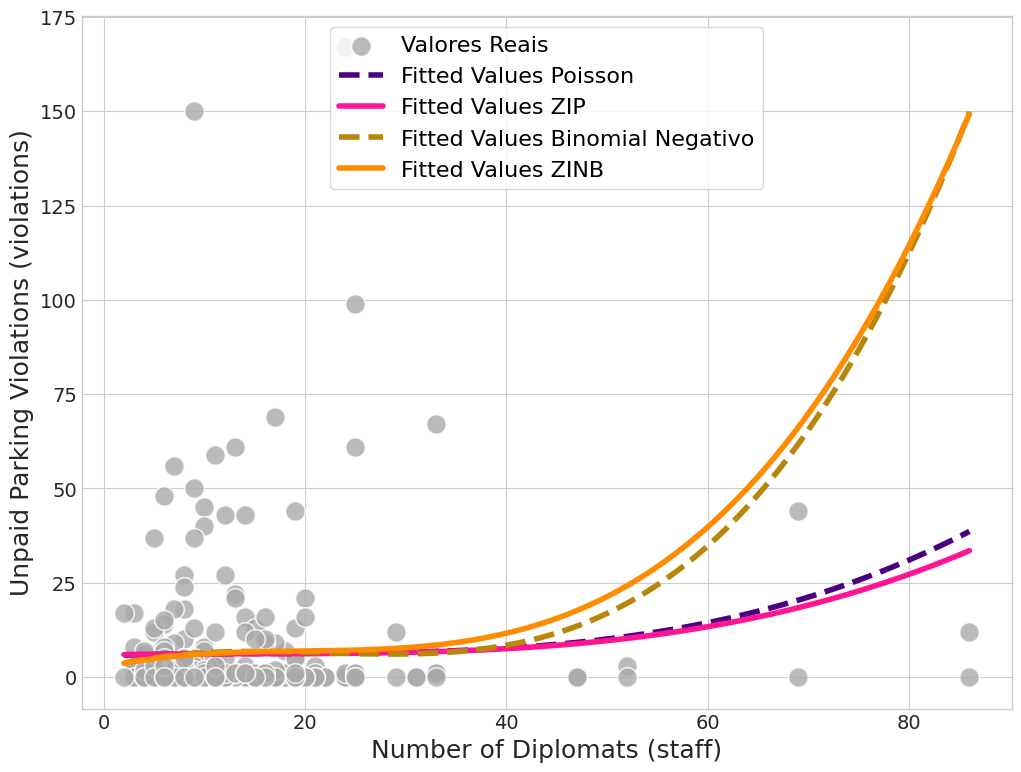

In [100]:
# In[47]: Fitted values dos modelos Poisson, BNeg, ZIP e ZINB, considerando,
#para fins didáticos, a variável dependente 'violations' em função apenas da
#variável preditora 'staff'

plt.figure(figsize=(12,9))
with plt.style.context('seaborn-v0_8-whitegrid'):
    sns.scatterplot(x='staff', y='violations', data=df_corruption, color='darkgrey',
                s=200, label='Valores Reais', alpha=0.8)
    sns.regplot(data=df_corruption, x='staff', y='fitted_poisson', order=3, ci=False,
            scatter=False, color='indigo',
            label='Fitted Values Poisson',
            line_kws={'linewidth': 4, 'linestyle': 'dashed'})
    sns.regplot(data=df_corruption, x='staff', y='fitted_zip', order=3, ci=False,
            scatter = False, color='deeppink',
            label='Fitted Values ZIP',
            line_kws={'linewidth': 4})
    sns.regplot(data=df_corruption, x='staff', y='fitted_bneg', order=3, ci=False,
            scatter = False, color='darkgoldenrod',
            label='Fitted Values Binomial Negativo',
            line_kws={'linewidth': 4, 'linestyle': 'dashed'})
    sns.regplot(data=df_corruption, x='staff', y='fitted_zinb', order=3, ci=False,
            scatter=False, color='darkorange',
            label='Fitted Values ZINB',
            line_kws={'linewidth': 4})
plt.xlabel('Number of Diplomats (staff)', fontsize=18)
plt.ylabel('Unpaid Parking Violations (violations)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', fontsize=16)
plt.show()

In [101]:
# In[48]: Gráfico para a comparação dos LogLiks dos modelos Poisson,
#binomial negativo, ZIP e ZINB

# Definição do dataframe com os modelos e respectivos LogLiks
df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg','ZINB'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_bneg.llf,
                                modelo_zinb.llf]})
df_llf

,modelo,loglik
0,Poisson,-2071.793753
1,ZIP,-1781.308425
2,BNeg,-567.401172
3,ZINB,-557.264368


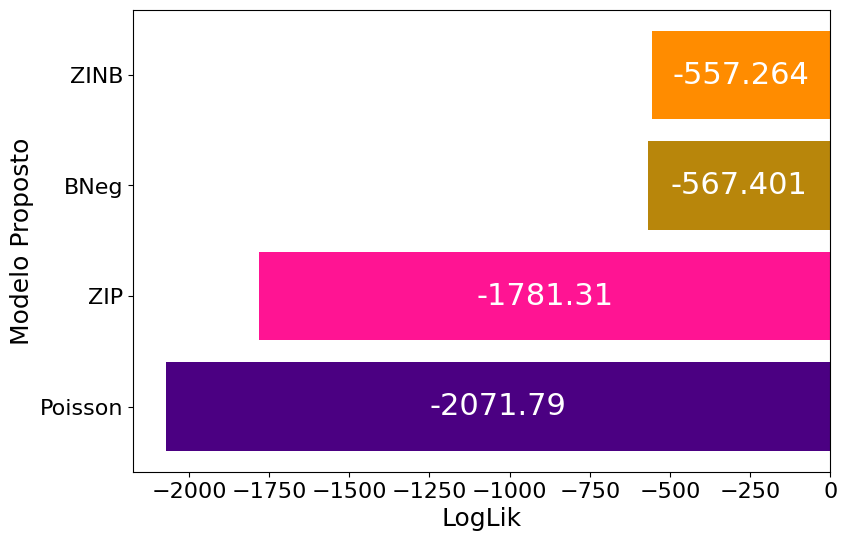

In [102]:
# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(9,6))

c = ['indigo', 'deeppink', 'darkgoldenrod', 'darkorange']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize=18)
ax.set_xlabel("LogLik", fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
plt.show()

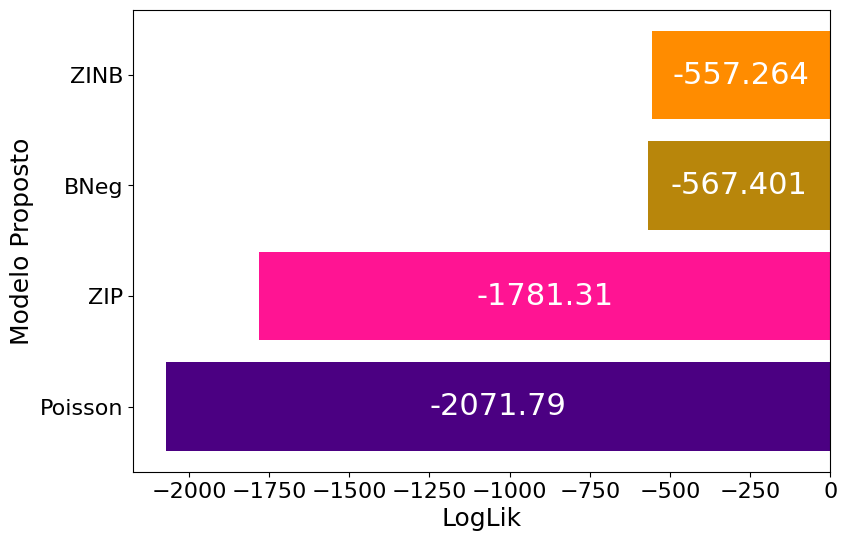

In [103]:
# In[49]: Gráfico para a comparação dos LogLiks dos modelos Poisson,
#binomial negativo, ZIP e ZINB, com JPG e som para fins didáticos

# Define a URL da imagem
url = "https://i.pinimg.com/originals/4a/ac/99/4aac9978c444c55cd462fd92c8ac400e.png"

# Carrega a imagem da URL
imagem = Image.open(urllib.request.urlopen(url))

# Define as dimensões e a posição desejada da imagem
nova_largura = 1700  # Largura da imagem redimensionada
nova_altura = 1700   # Altura da imagem redimensionada
posicao_x = 5500       # Posição horizontal da imagem
posicao_y = 4300       # Posição vertical da imagem

# Redimensiona a imagem
imagem_redimensionada = imagem.resize((nova_largura, nova_altura))

# Definição do dataframe com os modelos e respectivos LogLiks
df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg','ZINB'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_bneg.llf,
                                modelo_zinb.llf]})
df_llf

# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(9,6))

c = ['indigo', 'deeppink', 'darkgoldenrod', 'darkorange']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize=18)
ax.set_xlabel("LogLik", fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)

# Adiciona a imagem redimensionada em uma posição específica do gráfico
plt.figimage(imagem_redimensionada, posicao_x, posicao_y, zorder=1, alpha=0.73)

# Exibe o gráfico com a imagem
plt.show()

# Reproduz um som padrão (arquivo na pasta do curso)
# playsound('C:\\MBA DSA USP Esalq\\Modelos para Dados de Contagem\\sound.mp3')

################################## FIM ######################################

OBS: Não existe procedimento stepwise para modelos inflacionados de zeros

Resumo para escolha do modelo de contagem:

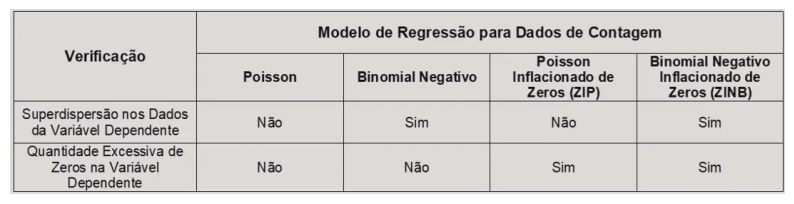

In [104]:
# Complementar
# Carregar a imagem
img = mpimg.imread('images/output_resumo_modelos_contagem.png')

# Exibir a imagem
plt.figure(figsize=(10,4))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

In [105]:
################################# COMPLEMENTAR ####################################
################################################################################### 
########################## COMPARAÇÃO COM MODELO LIENAR ########################### 

from statstests.tests import shapiro_francia 
from scipy.stats import boxcox

In [106]:
# Comparação com modelos estimados por OLS

modelo_linear = sm.OLS.from_formula('violations ~ staff + post + corruption',
                                    df_corruption).fit()

print(modelo_linear.summary())

                            OLS Regression Results                            
Dep. Variable:             violations   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     17.34
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           2.15e-10
Time:                        18:15:01   Log-Likelihood:                -1262.9
No. Observations:                 298   AIC:                             2534.
Df Residuals:                     294   BIC:                             2549.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.7926      1.756      5.577      

In [107]:
modelo_linear.llf

-1262.860739562314

In [108]:
# Teste de Shapiro-Francia nos resíduos do 'modelo_linear'
shapiro_francia(modelo_linear.resid)

method  :  Shapiro-Francia normality test
statistics W  :  0.5296850169142768
statistics z  :  9.933336529205448
p-value  :  1.4905497310055174e-23


{'method': 'Shapiro-Francia normality test',
 'statistics W': 0.5296850169142768,
 'statistics z': 9.933336529205448,
 'p-value': 1.4905497310055174e-23}

Não possui aderência à normalidade

In [110]:
# Transformação de Box-Cox na variável 'violations'

# yast, lmbda = boxcox(df_corruption['violations'])

# df_corruption['violations'].describe()

In [111]:
# Para consertar o erro 'ValueError: Data must be positive.'
df_corruption['violations1'] = df_corruption['violations'] + 0.001

df_corruption['violations1'].describe()

count    298.000000
mean       6.497644
std       18.210377
min        0.001000
25%        0.001000
50%        0.001000
75%        3.001000
max      167.001000
Name: violations1, dtype: float64

In [112]:
yast, lmbda = boxcox(df_corruption['violations1'])

df_corruption['bc_violations'] = yast

df_corruption

,country,code,violations,staff,post,corruption,lambda_poisson,ystar,fitted_poisson,fitted_bneg,fitted_zip,fitted_zinb,violations1,bc_violations
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208,15.919915,16.138592,14.823562,13.358543,50.001,3.463074
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289,0.216711,0.224603,0.203580,0.187939,1.001,0.000999
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843,13.371720,11.987630,12.877979,10.203814,17.001,2.592518
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023,0.182023,0.166834,0.176860,0.143555,0.001,-8.675434
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915,7.477915,5.551770,8.379367,7.494531,0.001,-8.675434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807,0.243691,0.243691,0.243691,0.253810,0.207250,0.183098,0.001,-8.675434
294,Zambia,ZMB,37,9,no,0.562193,13.486751,38.250347,13.486751,12.955688,13.616058,12.232444,37.001,3.226073
295,Zambia,ZMB,0,9,yes,0.562193,0.183589,0.183589,0.183589,0.180306,0.186996,0.172096,0.001,-8.675434
296,Zimbabwe,ZWE,43,14,no,0.133379,12.994217,65.979120,12.994217,13.033499,13.732195,13.896783,43.001,3.344928


In [113]:
# Estimar o novo modelo OLS com a trasnformação de Box-Cox

modelo_bc = sm.OLS.from_formula('bc_violations ~ staff + post + corruption',
                                    df_corruption).fit()

modelo_bc.summary()
modelo_bc.llf

shapiro_francia(modelo_bc.resid)

method  :  Shapiro-Francia normality test
statistics W  :  0.9635956199486321
statistics z  :  4.504131010053
p-value  :  3.3322542538854084e-06


{'method': 'Shapiro-Francia normality test',
 'statistics W': 0.9635956199486321,
 'statistics z': 4.504131010053,
 'p-value': 3.3322542538854084e-06}

In [114]:
# In[FINAL]: Gráfico para a comparação dos LogLiks dos modelos Poisson,
#binomial negativo, ZIP, ZINB, OLS e OLS com Box-Cox

# Definição do dataframe com os modelos e respectivos LogLiks
df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg','ZINB',
                                 'OLS Linear','OLS Box-Cox'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_bneg.llf,
                                modelo_zinb.llf,
                                modelo_linear.llf,
                                modelo_bc.llf]})
df_llf

,modelo,loglik
0,Poisson,-2071.793753
1,ZIP,-1781.308425
2,BNeg,-567.401172
3,ZINB,-557.264368
4,OLS Linear,-1262.860740
5,OLS Box-Cox,-803.491281


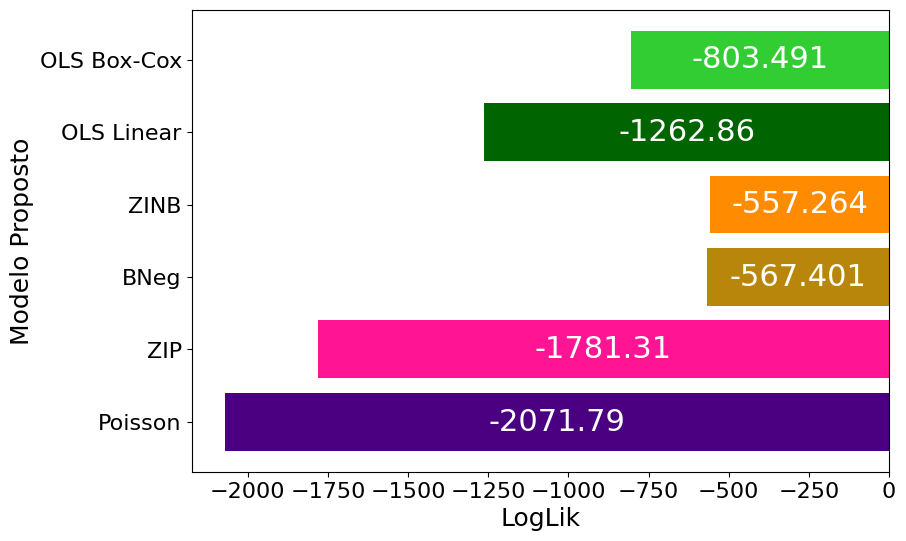

In [115]:
# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(9,6))

c = ['indigo', 'deeppink', 'darkgoldenrod', 'darkorange',
     'darkgreen','limegreen']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize=18)
ax.set_xlabel("LogLik", fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
plt.show()

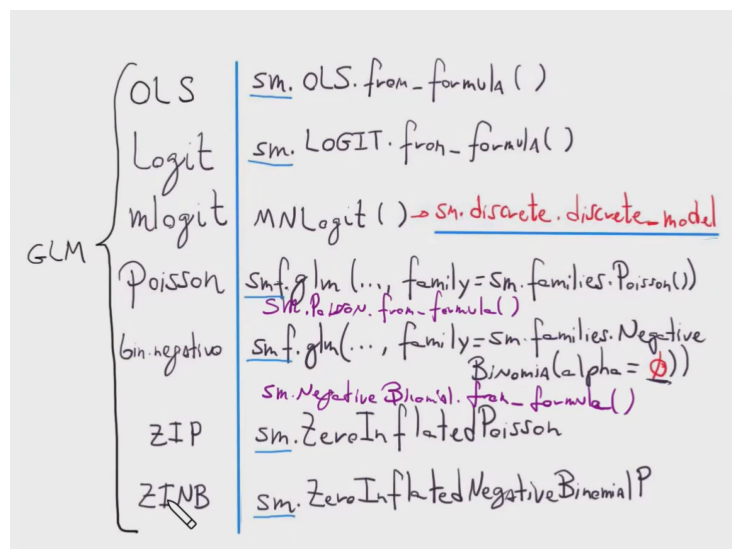

In [117]:
################################# COMPLEMENTAR ####################################
################################################################################### 
############################# RESUMO FUNÇÕES-MODELOS ############################## 

# Carregar a imagem
img = mpimg.imread('images/output_resumo_funcoes_modelos.png')

# Exibir a imagem
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()